<a href="https://colab.research.google.com/github/jinjinamanda/Detecter-des-faux-billets/blob/main/GONG_Jinjin_d%C3%A9tection_des_faux_billets_122023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

dfbillets = pd.read_csv('/content/billets.csv')
dfbillets_production = pd.read_csv('/content/billets_production.csv')

import warnings
warnings. simplefilter(action='ignore', category=Warning)

In [ ]:
# Affichage des premières lignes du fichier pour comprendre sa structure
dfbillets.head()

,is_genuine;diagonal;height_left;height_right;margin_low;margin_up;length
0,True;171.81;104.86;104.95;4.52;2.89;112.83
1,True;171.46;103.36;103.66;3.77;2.99;113.09
2,True;172.69;104.48;103.5;4.4;2.94;113.16
3,True;171.36;103.91;103.94;3.62;3.01;113.51
4,True;171.73;104.28;103.46;4.04;3.48;112.54


**1) Spécifier le séparateur pour la lecture des données du fichier billets.csv**

In [ ]:
dfbillets = pd.read_csv('/content/billets.csv', sep=';')
# Affichage des premières lignes pour vérifier la structure
dfbillets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


**2) Créer un un résumé statistique descriptif de toutes les colonnes numériques**

In [ ]:
# Basic statistical summary of the dataset
summary_statistics = dfbillets.describe()

# Checking for missing values in the dataset
missing_values = dfbillets.isnull().sum()

summary_statistics, missing_values

(          diagonal  height_left  height_right   margin_low    margin_up  \
 count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
 mean    171.958440   104.029533    103.920307     4.485967     3.151473   
 std       0.305195     0.299462      0.325627     0.663813     0.231813   
 min     171.040000   103.140000    102.820000     2.980000     2.270000   
 25%     171.750000   103.820000    103.710000     4.015000     2.990000   
 50%     171.960000   104.040000    103.920000     4.310000     3.140000   
 75%     172.170000   104.230000    104.150000     4.870000     3.310000   
 max     173.010000   104.880000    104.950000     6.900000     3.910000   
 
            length  
 count  1500.00000  
 mean    112.67850  
 std       0.87273  
 min     109.49000  
 25%     112.03000  
 50%     112.96000  
 75%     113.34000  
 max     114.44000  ,
 is_genuine       0
 diagonal         0
 height_left      0
 height_right     0
 margin_low      37
 margin_up        0
 len

In [ ]:
# Pourcentage de valeurs manquantes
missing_percentage = (missing_values / len(dfbillets)) * 100
missing_values, missing_percentage

(is_genuine       0
 diagonal         0
 height_left      0
 height_right     0
 margin_low      37
 margin_up        0
 length           0
 dtype: int64,
 is_genuine      0.000000
 diagonal        0.000000
 height_left     0.000000
 height_right    0.000000
 margin_low      2.466667
 margin_up       0.000000
 length          0.000000
 dtype: float64)

**3) Utiliser la régression linéaire pour l'analyse et la modélisation des données.**

In [ ]:
data_with_margin = dfbillets.dropna(subset=['margin_low'])
data_without_margin = dfbillets[dfbillets['margin_low'].isnull()]

# Separating features and target variable for the regression model
X = data_with_margin.drop(['is_genuine', 'margin_low'], axis=1)
y = data_with_margin['margin_low']

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluating the model on the test set
model_score = model.score(X_test, y_test)

# Predicting the missing values in the dataset
X_missing = data_without_margin.drop(['is_genuine', 'margin_low'], axis=1)
predicted_margin_low = model.predict(X_missing)

# Filling the missing values in the original dataset
dfbillets.loc[dfbillets['margin_low'].isnull(), 'margin_low'] = predicted_margin_low

dfbillets.isnull().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,0
margin_up,0
length,0


**4) Evaluer la performance du modèle de la régression linéaire.**

In [ ]:
# Predicting on the test set and calculating the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

0.2520455085066653

Cette ligne calcule la MSE(Une erreur quadratique moyenne) entre les valeurs réelles (y_test) et les valeurs prédites (y_pred). MSE=0.25, cela signifie que la performance du modèle de la régression linéaire est correcte.

**5) Identifier la présence de multicolinéarité dans les données utilisées pour une régression linéaire.**


In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Préparation des données pour le calcul du VIF, en utilisant les données imputées
numeric_data_imputed_user = dfbillets.select_dtypes(include=[np.number])
numeric_data_with_constant_imputed_user = add_constant(numeric_data_imputed_user)

# Calcul du VIF pour chaque variable numérique dans les données imputées
vif_data_imputed_user = pd.DataFrame()
vif_data_imputed_user["Variable"] = numeric_data_imputed_user.columns
vif_data_imputed_user["VIF"] = [variance_inflation_factor(numeric_data_with_constant_imputed_user.values, i)
                                for i in range(1, numeric_data_with_constant_imputed_user.shape[1])]

vif_data_imputed_user

,Variable,VIF
0,diagonal,1.017948
1,height_left,1.158774
2,height_right,1.260462
3,margin_low,1.936807
4,margin_up,1.419547
5,length,2.140908


Ces valeurs indiquent qu'il n'y a pas de corrélation importante entre les variables, puisque toutes les valeurs de VIF sont bien en dessous du seuil généralement utilisé de 5 ou 10.

**6) Evaluer les résidus d'un modèle de la régression linéaire.**

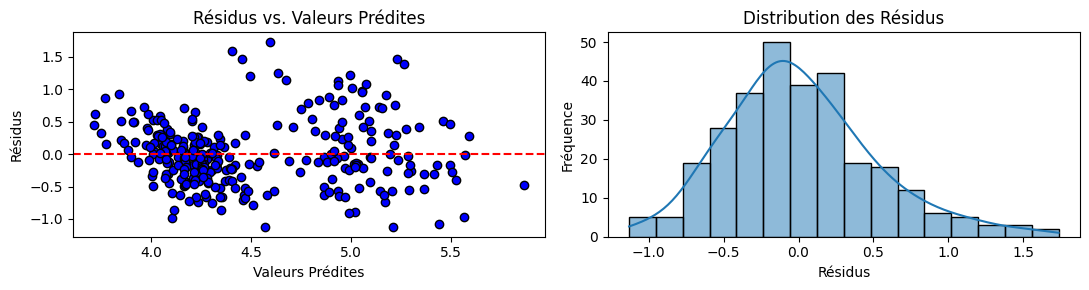

In [ ]:
# Prédire les valeurs sur l'ensemble de test pour calculer les résidus
y_pred = model.predict(X_test)

# Calculer les résidus comme différence entre les valeurs observées et prédites
residus = y_test - y_pred

# Visualisation des résidus
plt.figure(figsize=(11, 3))

# Scatter plot des résidus par rapport aux valeurs prédites
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residus, color='blue', edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Résidus vs. Valeurs Prédites')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')

# Histogramme des résidus
plt.subplot(1, 2, 2)
sns.histplot(residus, kde=True)
plt.title('Distribution des Résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()


**Résidus vs. Valeurs Prédites**
Le graphique des résidus par rapport aux valeurs prédites ne montre pas de motifs clairs, ce qui est généralement bon signe. Cela suggère que le modèle traite de manière cohérente les erreurs sur l'ensemble des valeurs prédites.
La distribution autour de la ligne horizontale rouge (y=0) semble relativement uniforme, indiquant que le modèle n'est pas biaisé vers des sur-estimations ou sous-estimations systématiques pour certaines plages de valeurs.
**Distribution des Résidus**
L'histogramme des résidus, avec la courbe de densité, montre la distribution des erreurs (résidus) que le modèle a faites sur l'ensemble de test.
Idéalement, cette distribution devrait être proche d'une distribution normale (gaussienne), centrée autour de zéro. La forme de la distribution dans cet histogramme semble relativement symétrique autour de zéro, ce qui est un bon signe.

7) **Méthodes de Prédiction à Comparer: Régression logistique**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Preparing the data for training
X = dfbillets.drop('is_genuine', axis=1)
y = dfbillets['is_genuine'].astype(int)  # Converting boolean to integer for model training

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating and training the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = logistic_model.predict(X_test)

# Evaluating the model
model_score = logistic_model.score(X_test, y_test)
report = classification_report(y_true=y_test, y_pred=y_pred,digits=4)
print(model_score)
print(report)

0.9933333333333333
              precision    recall  f1-score   support

           0     0.9897    0.9897    0.9897        97
           1     0.9951    0.9951    0.9951       203

    accuracy                         0.9933       300
   macro avg     0.9924    0.9924    0.9924       300
weighted avg     0.9933    0.9933    0.9933       300



L'accuracy globale du modèle sur l'ensemble de test est de 0.9933, ce qui signifie que 99.33% des prédictions étaient correctes. Ces scores élevés suggèrent que le modèle a une très bonne performance sur les données de test.

**8) Créer la matrice de confusion pour le modèle de la régression logistique.**

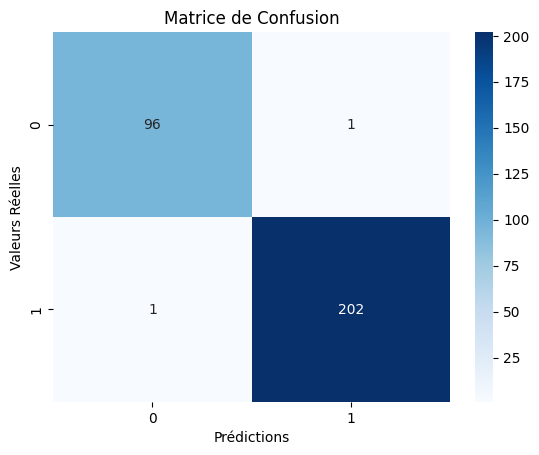

In [ ]:
# Construction de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


La matrice de confusion montre 96 faux positifs (faux billets correctement
identifiés), 1 faux négatif (vrai billet identifié à tort comme faux), 1 varis négatif (faux billet identifié à tort comme vrai), et 202 vrais positifs (vrais billets correctement identifiés).
La répartition des erreurs montre que le modèle est très précis avec très peu d'erreurs.

**9) Méthodes de Prédiction à Comparer: méthode k-means**

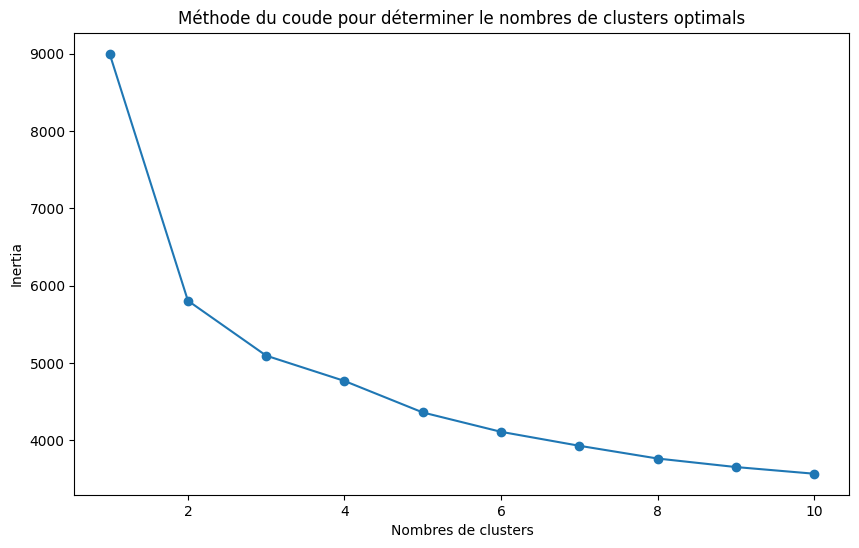

In [ ]:
# Step 1: Normalization of the data (excluding the target variable and the column with missing values)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dfbillets.drop(columns=['is_genuine']))

# Step 2: Determining the optimal number of clusters for K-Means
# We'll use the elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude pour déterminer le nombres de clusters optimals')
plt.xlabel('Nombres de clusters')
plt.ylabel('Inertia')
plt.show()

**10) Normaliser des données.**

In [ ]:
# Séparer les caractéristiques et la colonne is_genuine
features = dfbillets.drop('is_genuine', axis=1)
is_genuine = dfbillets['is_genuine']

# Initialiser le StandardScaler
scaler = StandardScaler()

# Ajuster et transformer les caractéristiques
scaled_features = scaler.fit_transform(features)

# Créer un DataFrame avec les caractéristiques normalisées
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Recombiner avec la colonne is_genuine
normalized_billets_data = pd.concat([scaled_features_df, is_genuine.reset_index(drop=True)], axis=1)

In [ ]:
print(scaled_features_df)

      diagonal  height_left  height_right  margin_low  margin_up    length
0    -0.486540     2.774123      3.163240    0.055542  -1.128325  0.173651
1    -1.633729    -2.236535     -0.799668   -1.081881  -0.696799  0.471666
2     2.397823     1.504756     -1.291191   -0.126446  -0.912562  0.551901
3    -1.961498    -0.399294      0.060498   -1.309366  -0.610494  0.953075
4    -0.748754     0.836669     -1.414072   -0.672409   1.417677 -0.158750
...        ...          ...           ...         ...        ...       ...
1495 -0.683201     1.170713      0.767063   -0.096114  -0.265273 -1.602978
1496  0.758981     2.005822      1.596509    1.192966   0.942999 -1.958303
1497 -0.519316    -0.065250      0.613462    1.556942   0.899846 -0.835016
1498  0.332882     0.836669      0.429141    1.041310   1.331372 -0.491152
1499 -1.600953     0.402412     -0.308144    0.222364   0.942999 -0.697470

[1500 rows x 6 columns]


In [ ]:
print(normalized_billets_data)

      diagonal  height_left  height_right  margin_low  margin_up    length  \
0    -0.486540     2.774123      3.163240    0.055542  -1.128325  0.173651   
1    -1.633729    -2.236535     -0.799668   -1.081881  -0.696799  0.471666   
2     2.397823     1.504756     -1.291191   -0.126446  -0.912562  0.551901   
3    -1.961498    -0.399294      0.060498   -1.309366  -0.610494  0.953075   
4    -0.748754     0.836669     -1.414072   -0.672409   1.417677 -0.158750   
...        ...          ...           ...         ...        ...       ...   
1495 -0.683201     1.170713      0.767063   -0.096114  -0.265273 -1.602978   
1496  0.758981     2.005822      1.596509    1.192966   0.942999 -1.958303   
1497 -0.519316    -0.065250      0.613462    1.556942   0.899846 -0.835016   
1498  0.332882     0.836669      0.429141    1.041310   1.331372 -0.491152   
1499 -1.600953     0.402412     -0.308144    0.222364   0.942999 -0.697470   

      is_genuine  
0           True  
1           True  
2     

**11) Créer le cercle de corrélation afin de représenter les relations entre les variables et les composantes principales.**

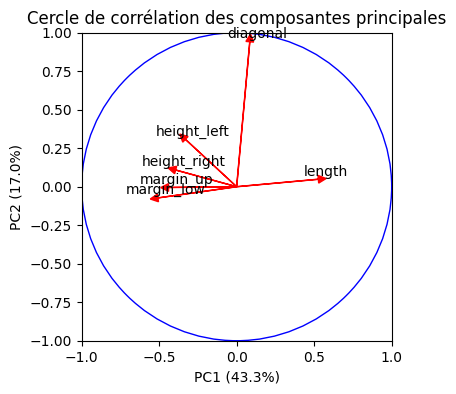

In [ ]:
# Création de l'objet PCA
pca = PCA()

# Application de l'ACP sur les données numériques mises à jour
pca_data = pca.fit_transform(scaled_features_df)

# Création du cercle de corrélation
fig, ax = plt.subplots(figsize=(4, 4))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
ax.add_artist(circle)

# Afficher les flèches pour les composantes principales
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    ax.arrow(0, 0, comp1, comp2, head_width=0.05, head_length=0.05, color='red')
    # Assurez-vous de compléter la ligne ci-dessous correctement
    plt.text(comp1 + 0.05, comp2 + 0.05, scaled_features_df.columns[i], color='black', ha='center', va='center')

# Limiter les axes pour une meilleure visibilité
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Titres et labels
plt.xlabel('PC1 ({}%)'.format(round(100 * pca.explained_variance_ratio_[0], 1)))
plt.ylabel('PC2 ({}%)'.format(round(100 * pca.explained_variance_ratio_[1], 1)))
plt.title('Cercle de corrélation des composantes principales')

# Afficher le graphique
plt.show()


**12) Créer une graphique ACP pour comprendre les composantes principales.**

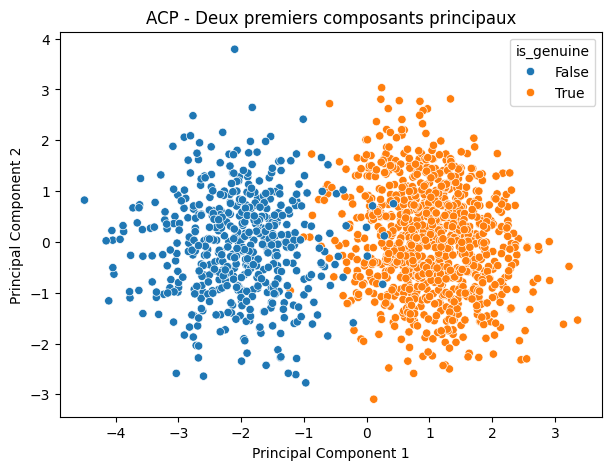

In [ ]:
# Exclusion de la colonne 'is_genuine' pour l'ACP
X = dfbillets.drop('is_genuine', axis=1)

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Application de l'ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Création d'un DataFrame pour la visualisation
pca_df = pd.DataFrame(data = X_pca, columns = ['Principal Component 1', 'Principal Component 2'])
pca_df['is_genuine'] = dfbillets['is_genuine']

# Visualisation des deux premiers composants principaux
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='is_genuine', data=pca_df)
plt.title('ACP - Deux premiers composants principaux')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Supposons que X_scaled est votre ensemble de données normalisé
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Pourcentage de variance expliquée par les composants
explained_variance = pca.explained_variance_ratio_

# Afficher le pourcentage de variance expliquée
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%}")

# Pour obtenir la variance expliquée cumulée
cumulative_variance = explained_variance.cumsum()
print(f"Cumulative explained variance: {cumulative_variance[-1]:.2%}")


Principal Component 1: 43.29%
Principal Component 2: 16.96%
Cumulative explained variance: 60.25%


**12) Présenter la méthode Kmeans en utilisant les centroïdes pour la prédiction.**

In [ ]:
# Calculating the centroids of the clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data)
centroids = kmeans.cluster_centers_

# Converting centroids to a DataFrame for better readability
centroids_df = pd.DataFrame(scaler.inverse_transform(centroids), columns=features.columns)

# Display the centroids of each cluster
centroids_df

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.987729,103.945129,103.805588,4.119130,3.052540,113.196066
1,171.899153,104.200383,104.152520,5.220681,3.351734,111.630847


In [ ]:

# Preparing the data for training
X = scaled_features_df
y = normalized_billets_data['is_genuine'].astype(int)  # Converting boolean to integer for model training

# Applying KMeans clustering
# We expect 2 clusters corresponding to genuine and counterfeit bills
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Predicting the clusters
clusters = kmeans.predict(X)

# Mapping clusters to true/false values
# To do this, we will check which cluster most genuine bills belong to
cluster_mapping = {0: True, 1: False} # La variable cluster_mapping est un dictionnaire initial qui associe arbitrairement le cluster 0 à True et le cluster 1 à False.
genuine_cluster = np.argmax(np.bincount(clusters[y == 1])) # identifie le cluster avec le plus grand nombre de vrais billets
fake_cluster = 1 - genuine_cluster
cluster_mapping[genuine_cluster] = True #  le cluster qui contient le plus grand nombre de billets authentiques.
cluster_mapping[fake_cluster] = False # l'autre cluster.
# cluster_mapping est mis à jour pour que le genuine_cluster soit associé à True et le fake_cluster à False.

# Assigning predicted labels based on clusters
predicted_labels = np.array([cluster_mapping[cluster] for cluster in clusters])
# predicted_labels est un tableau qui contient les valeurs vrai/faux prédites pour chaque observation basée sur le cluster auquel elle appartient

# Evaluation metrics for K-Means
conf_matrix_kmeans = confusion_matrix(y, predicted_labels)
report_kmeans = classification_report(y, predicted_labels,digits=4)

# y_true=y_test, y_pred=y_pred,digits=4
# Comparing predicted labels with actual labels
kmeans_accuracy = np.mean(predicted_labels == y)  # calcul la proportion des prédictions correctes.

# kmeans_accuracy calcule la précision du clustering en comparant les étiquettes prédites (predicted_labels)
# avec les étiquettes réelles (y). La précision est la proportion de prédictions correctes.
print(kmeans_accuracy)
print(report_kmeans)


0.9846666666666667
              precision    recall  f1-score   support

           0     0.9799    0.9740    0.9769       500
           1     0.9870    0.9900    0.9885      1000

    accuracy                         0.9847      1500
   macro avg     0.9835    0.9820    0.9827      1500
weighted avg     0.9847    0.9847    0.9847      1500



**13) Créer la matrice de confusion avec la méthode k-means.**

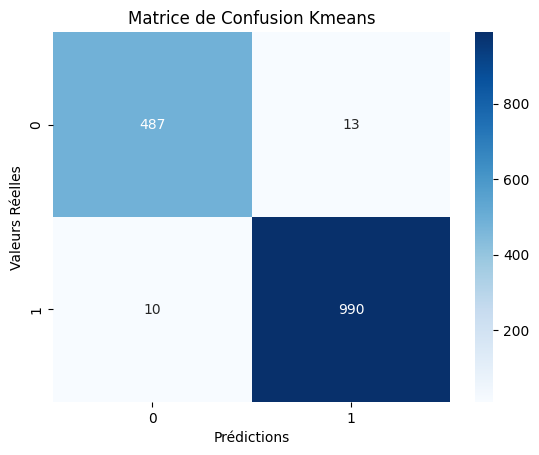

In [ ]:
# Construction de la matrice de confusion
conf_matrix_kmeans = confusion_matrix(y, predicted_labels)

# Affichage de la matrice de confusion avec Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix_kmeans, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion Kmeans')
plt.show()


**14) Choisir et comparer les méthodes de Prédiction.**

In [ ]:
print("Performance de la régression logistque")
print(model_score)
print(report)
print("Performance de la méthode Kmeans")
print(kmeans_accuracy)
print(report_kmeans)

Performance de la régression logistque
0.9933333333333333
              precision    recall  f1-score   support

           0     0.9897    0.9897    0.9897        97
           1     0.9951    0.9951    0.9951       203

    accuracy                         0.9933       300
   macro avg     0.9924    0.9924    0.9924       300
weighted avg     0.9933    0.9933    0.9933       300

Performance de la méthode Kmeans
0.9846666666666667
              precision    recall  f1-score   support

           0     0.9799    0.9740    0.9769       500
           1     0.9870    0.9900    0.9885      1000

    accuracy                         0.9847      1500
   macro avg     0.9835    0.9820    0.9827      1500
weighted avg     0.9847    0.9847    0.9847      1500



La méthode de la régression logistique est plus performante: 0.993 vs 0.984

**15) Créer un algorhithme automatique afin de détecter les vrais et les faux billets.**

In [ ]:
print(dfbillets_production)

   diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5


In [ ]:
# Réentraînement du modèle de régression logistique
logistic_model_final = LogisticRegression(random_state=42)
logistic_model_final.fit(X, y)

# Fonction pour prédire l'authenticité
def predict_authenticity_log_reg(dfbillets_production, model, scaler):
    print(dfbillets_production)

    # Suppression de la colonne 'id' si nécessaire
    df = dfbillets_production.drop(['id'], axis=1, errors='ignore')

    # Normalisation des données
    features_scaled = scaler.transform(df)

    # Prédiction avec le modèle
    predictions = model.predict(features_scaled)

    # Obtenir les probabilités pour la classe "authentique"
    probabilities = model.predict_proba(features_scaled)[:, 1]

    # Ajouter les prédictions et les probabilités au DataFrame
    dfbillets_production['predicted_authenticity'] = predictions.astype(bool)
    dfbillets_production['authenticity_probability'] = probabilities

    return dfbillets_production

dfbillets_test= pd.read_csv('/content/billets_production.csv')
dfbillets_production = predict_authenticity_log_reg(dfbillets_test, logistic_model_final, scaler)
dfbillets_production.head()

   diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5


,diagonal,height_left,height_right,margin_low,margin_up,length,id,predicted_authenticity,authenticity_probability
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,0.001066
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,0.000149
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,0.000251
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,0.979167
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.999864
